In [ ]:
!pip install furo
#!pip install graphviz
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install prettytable
!pip install scikit-learn
!pip install scipy
!pip install setuptools
!pip install sphinx-gallery
!pip install sphinxemoji
!pip install termcolor
!pip install pydotplus
#!winget install -e --id Graphviz.Graphviz

!pip install trustee --user

^C


In [1]:
import numpy as np
import csv
import pandas as pd
import os
import shutil
import joblib
import pydotplus
import graphviz

from sklearn import tree

from trustee import ClassificationTrustee
from trustee.utils.tree import get_dt_info, top_k_prune

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# DO NOT RUN (this is for the colab zip)
"""
labels = ['Youtube', 'GoogleDoc', 'GoogleDrive']

features_path = "G:/features"
save_path = "G:/features/colab"

for label in labels:
    folder_path = os.path.join(features_path, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('0.npy'):
            file_path = os.path.join(folder_path, filename)
            # Load the .npy file and sum
            temp = np.load(file_path)
            np.save(os.path.join(save_path, filename), temp)
"""

In [ ]:
# LOAD DATASET

labels = ['Youtube', 'GoogleDoc', 'GoogleDrive']

features_path = "features"

df = pd.DataFrame()

pca = PCA(n_components=100)

for label in labels:
    folder_path = os.path.join(features_path, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('0.npy'):
            file_path = os.path.join(folder_path, filename)
            # Load the .npy file and sum
            temp = np.load(file_path)

            # Apply Singular Value Decomposition (SVD) for dimensionality reduction
            pca.fit(temp)
            new_row = pd.DataFrame([np.append(label, pca.singular_values_)] , columns=[f'feature_{i}' for i in range(101)])
            # Append the new row to the DataFrame
            df = pd.concat([df, new_row], ignore_index=True)

In [ ]:
df

In [18]:
df.to_csv("df_pca.csv", index=False)

In [2]:
# Load the df
df = pd.read_csv("df_pca.csv")

y = df['feature_0']
X = df.drop(columns = ['feature_0'], inplace = False)

# Split the data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training set
classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
test_score = classifier.score(X_test, y_test)
print("Test set accuracy:", test_score)

Test set accuracy: 0.9793510324483776


In [12]:
 #joblib.dump(classifier, 'quic_text_rf_pca.joblib') # put model here to export

['quic_text_rf_pca.joblib']

In [3]:
y_pred = classifier.predict(X_test)

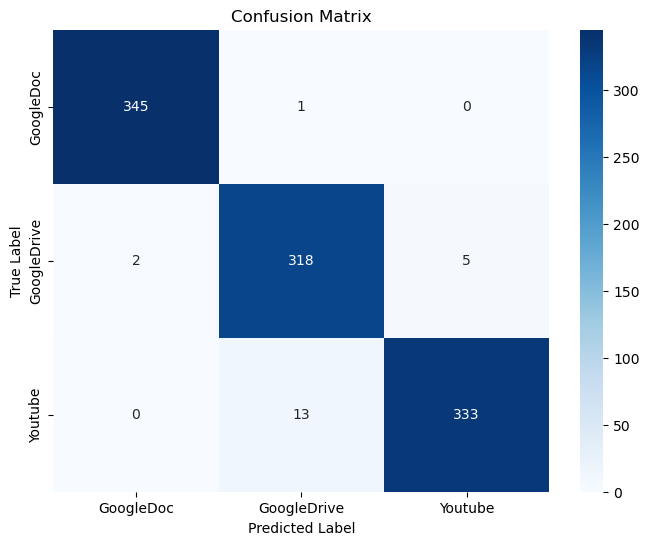

In [4]:
# Generate the confusion matrix
category_labels = ['GoogleDoc', 'GoogleDrive', 'Youtube']
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Trustee

In [5]:
# Load the trained model
#model = joblib.load('quic_text_rf_pca.joblib')
num_iter=5
num_stability_iter=2

trustee = ClassificationTrustee(expert=classifier)
trustee.fit(X_train, y_train, num_iter=num_iter, num_stability_iter=num_stability_iter, samples_size=0.3, verbose=True)
dt, pruned_dt, agreement, reward = trustee.explain()
dt_y_pred = dt.predict(X_test)
pruned_dt_y_pred = pruned_dt.predict(X_test)

all_trees = trustee.get_all_students()


print("Model explanation global fidelity report:")
print(classification_report(y_pred, dt_y_pred))
print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))

Initializing training dataset using RandomForestClassifier(random_state=42) as expert model
Expert model score: 1.0
Initializing Trustee outer-loop with 2 iterations
########## Outer-loop Iteration 0/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/5 ##########
Sampling 498 points from training dataset with (1660, 1660) entries
Student model 0-0 trained with depth 7 and 15 leaves:
Student model score: 0.9133243994152848
Student model 0-0 fidelity: 0.9133243994152848
########## Inner-loop Iteration 1/5 ##########
Sampling 498 points from training dataset with (1810, 1810) entries
Student model 0-1 trained with depth 8 and 17 leaves:
Student model score: 0.9522205630219568
Student model 0-1 fidelity: 0.9522205630219568
########## Inner-loop Iteration 2/5 ##########
Sampling 498 points from training dataset with (1960, 1960) entries
Student model 0-2 trained with depth 5 and 14 leaves:
Student model score: 0.9686856491680809
Student model 0-

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [6]:
# Output decision tree to pdf
features = ['feature_{}'.format(i) for i in range(1, 101)]
classes = ['GoogleDoc', 'GoogleDrive', 'Youtube']

dot_data = tree.export_graphviz(
    dt,
    class_names=classes,
    feature_names= features,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("flowpic_rf_dt")

# Output pruned decision tree to pdf
dot_data = tree.export_graphviz(
    pruned_dt,
    class_names=classes,
    feature_names=features,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("flowpic_rf_pruned_dt")

all_features = {}
i=0
for j in range(num_stability_iter):
    for dt, rev in all_trees[j]:
        dot_data = tree.export_graphviz(
            dt,
            class_names=classes,
            feature_names=features,
            filled=True,
            rounded=True,
            special_characters=True,)
        graph = graphviz.Source(dot_data)
        graph.render(f'pca tree {i}')    

        features_used, splits, branches = get_dt_info(dt)

        for feat in features_used:
            if feat not in all_features:
                all_features[feat] = {"count_total": 0, "num_trees": 0, "samples": 0}

            all_features[feat]["count_total"] += features_used[feat]["count"]
            all_features[feat]["num_trees"] += 1
            all_features[feat]["samples"] += features_used[feat]["samples"]

        
        print(f'tree {i}:')
        for feat in features_used:   
            print(f'feat: {feat+1}, count: {features_used[feat]["count"]}, samples: {features_used[feat]["samples"]}')
        
        i+=1

print()
print("all tree:")    
for feat in all_features:   
     print(f'feat: {feat+1}, count_total: {all_features[feat]["count_total"]}, num_trees: {all_features[feat]["num_trees"]}, samples: {all_features[feat]["samples"]}')


print()
sorted_features = sorted(all_features.items(), key=lambda x: (x[1]["num_trees"], x[1]["samples"]), reverse=True)
print("sorted features:")
for feat, data in sorted_features:
    print(f'feat: {feat + 1}, count_total: {data["count_total"]}, num_trees: {data["num_trees"]}, samples: {data["samples"]}')
    

tree 0:
feat: 16, count: 2, samples: 451
feat: 99, count: 1, samples: 114
feat: 1, count: 3, samples: 343
feat: 64, count: 2, samples: 247
feat: 31, count: 1, samples: 7
feat: 4, count: 1, samples: 101
feat: 29, count: 1, samples: 2
feat: 5, count: 1, samples: 99
feat: 48, count: 1, samples: 7
feat: 3, count: 1, samples: 4
tree 1:
feat: 5, count: 1, samples: 348
feat: 16, count: 1, samples: 98
feat: 4, count: 1, samples: 96
feat: 2, count: 2, samples: 210
feat: 17, count: 1, samples: 5
feat: 21, count: 1, samples: 2
feat: 1, count: 1, samples: 250
feat: 13, count: 1, samples: 118
feat: 73, count: 1, samples: 132
feat: 30, count: 1, samples: 118
feat: 3, count: 1, samples: 115
feat: 33, count: 1, samples: 3
feat: 36, count: 1, samples: 112
feat: 23, count: 1, samples: 6
feat: 93, count: 1, samples: 14
tree 2:
feat: 5, count: 2, samples: 463
feat: 80, count: 1, samples: 111
feat: 56, count: 1, samples: 108
feat: 2, count: 2, samples: 7
feat: 44, count: 2, samples: 252
feat: 38, count: 1,